# Tae-Seung Kim Module 8

col info here https://search.r-project.org/CRAN/refmans/creditmodel/html/lendingclub.html

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [53]:
old_data = pd.read_csv('fullacc_2007_2016.csv')

C:\Users\tkkim\AppData\Local\Temp\ipykernel_24232\3082313150.py:1: DtypeWarning: Columns (19,49,59,129,130,131,134,135,136,139) have mixed types. Specify dtype option on import or set low_memory=False.
  old_data = pd.read_csv('fullacc_2007_2016.csv')


## Dates to dates

In [54]:
old_data['issue_d'] = pd.to_datetime(old_data['issue_d'])

old_data['last_credit_pull_d'] = pd.to_datetime(old_data['last_credit_pull_d'])

old_data['earliest_cr_line'] = pd.to_datetime(old_data['earliest_cr_line'])

# make credit
old_data['credit_age'] = old_data['issue_d'] - old_data['earliest_cr_line']

# time since last inq
old_data['time_since_last_inq'] = old_data['issue_d'] - old_data['last_credit_pull_d']

# drop dates now
old_data = old_data.drop(['issue_d', 'last_credit_pull_d', 'earliest_cr_line'], axis=1)


C:\Users\tkkim\AppData\Local\Temp\ipykernel_24232\2090973682.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  old_data['last_credit_pull_d'] = pd.to_datetime(old_data['last_credit_pull_d'])
C:\Users\tkkim\AppData\Local\Temp\ipykernel_24232\2090973682.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  old_data['earliest_cr_line'] = pd.to_datetime(old_data['earliest_cr_line'])


## Remove useless columns

In [55]:
# drop member_id & URL and set index to id
# also drop title and desc as purpose is more useful and URL
old_data = old_data.drop(['member_id','url','desc', 'title'], axis=1)
old_data.set_index('id', inplace=True, drop=True)

# drop all the columns with sec_app in the name because they are all NaN
old_data = old_data.drop([col for col in old_data.columns if 'sec_app' in col], axis=1)

# drop all the hardship stuff because it's post loan issue
old_data = old_data.drop([col for col in old_data.columns if 'hardship' in col], axis=1)

# we'll do the same for settlement
old_data = old_data.drop([col for col in old_data.columns if 'settlement' in col], axis=1)

# join application stuff can also be dropped. ind/join can be flagged off application_type
old_data = old_data.drop([col for col in old_data.columns if 'joint' in col], axis=1)

# we can drop the last and next payment date columns because it's post loan issue
old_data = old_data.drop([col for col in old_data.columns if 'last_pymnt' in col or 'next_pymnt' in col], axis=1)

# drop zip because it is obfuscated and i'm sure that using it violates FHA, CRA or FLCA or something
old_data = old_data.drop('zip_code', axis=1)

# drop recoveries and fees because they're post default
old_data = old_data.drop(['recoveries', 'collection_recovery_fee'], axis=1)

# drop more post default cols and pymnt since we're predicting the probability of default on loan issue 
old_data = old_data.drop(["out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv",  "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "pymnt_plan"], axis=1)

# drop grade for now, high int rate means lower grade
old_data = old_data.drop(['grade', 'sub_grade'], axis=1)

# drop job title. Self reported titles are not useful. Industry would be useful but we don't have that
old_data = old_data.drop('emp_title', axis=1)

# drop policy code, only 1 value
old_data = old_data.drop('policy_code', axis=1)

# drop funded amounts because they're tied to probability of default
old_data = old_data.drop(['funded_amnt', 'funded_amnt_inv'], axis=1)

## Make target 

In [56]:
# create our target variable. 1 = defaulted, 0 = not
old_data['target'] = old_data['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Does not meet the credit policy. Status:Charged Off', 'Default'] else 0)

# drop loan status
old_data = old_data.drop(['loan_status'], axis=1)

In [57]:
# first pass cleanse, let's delete anything above 20% missing since imputing it would be bad
tempdf = (old_data.isnull().sum()/old_data.shape[0]).reset_index()
tempdf = tempdf[tempdf[0] > .20]

for col in tempdf['index']:
    old_data = old_data.drop(col, axis=1)

In [58]:
tempdf = (old_data.isnull().sum()/old_data.shape[0]).reset_index()
tempdf[tempdf[0] > 0]

,index,0
4,emp_length,0.055263
6,annual_inc,0.000003
10,dti,0.000049
11,delinq_2yrs,0.000022
14,inq_last_6mths,0.000023
15,open_acc,0.000022
16,pub_rec,0.000022
18,revol_util,0.000579
19,total_acc,0.000022
23,collections_12_mths_ex_med,0.000110


In [59]:
# now that we've gotten rid of the worst offenders, lets drop instead of imputing
dropped = old_data.dropna()
print(f"remaining rows: {dropped.shape[0]}")
print(f"% left: {dropped.shape[0]/old_data.shape[0]*100:.2f}%")

remaining rows: 980148
% left: 74.15%


In [60]:
# print out the ratio of the target variable
# looks like they're pretty close and we helped the imbalance a tiny percentage
print('-------DROPPED-------')
print(dropped['target'].value_counts(normalize=True))
print('-------OLD DATA-------')
print(old_data['target'].value_counts(normalize=True))

-------DROPPED-------
target
0    0.830366
1    0.169634
Name: proportion, dtype: float64
-------OLD DATA-------
target
0    0.83257
1    0.16743
Name: proportion, dtype: float64


In [61]:
#also change timedelta to int
dropped['credit_age'] = dropped['credit_age'].dt.days.astype(int)
dropped['time_since_last_inq'] = dropped['time_since_last_inq'].dt.days.astype(int)

C:\Users\tkkim\AppData\Local\Temp\ipykernel_24232\2036891866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped['credit_age'] = dropped['credit_age'].dt.days.astype(int)
C:\Users\tkkim\AppData\Local\Temp\ipykernel_24232\2036891866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped['time_since_last_inq'] = dropped['time_since_last_inq'].dt.days.astype(int)


## Encoding

In [62]:
num_cols = old_data.select_dtypes(exclude='O') .columns.to_list()
str_cols = old_data.select_dtypes(include='O').columns.to_list()

len(num_cols)+ len(str_cols) == old_data.shape[1]

True

In [63]:
# check to make sure we dont have crazy cradinality
bigholder = []
for col in str_cols:
    small_holder = {}
    small_holder['col'] = col
    small_holder['unique'] = old_data[col].nunique()
    bigholder.append(small_holder)

str_uniq_df = pd.DataFrame(bigholder)
str_uniq_df

,col,unique
0,term,2
1,emp_length,11
2,home_ownership,6
3,verification_status,3
4,purpose,14
5,addr_state,51
6,initial_list_status,2
7,application_type,2
8,disbursement_method,2


In [64]:
#o one hot encode the string columns and drop the originals
encoded = dropped.copy(deep=True)
for i in str_cols:
    prefix_name = 'z_' + i
    y = pd.get_dummies(dropped[i],prefix=prefix_name,drop_first=True)
    encoded = pd.concat([encoded,y],axis=1)
    encoded = encoded.drop(i,axis=1)

## Outliers

For now we'll ignore outliers since they're actual datapoints and can occur in the real world

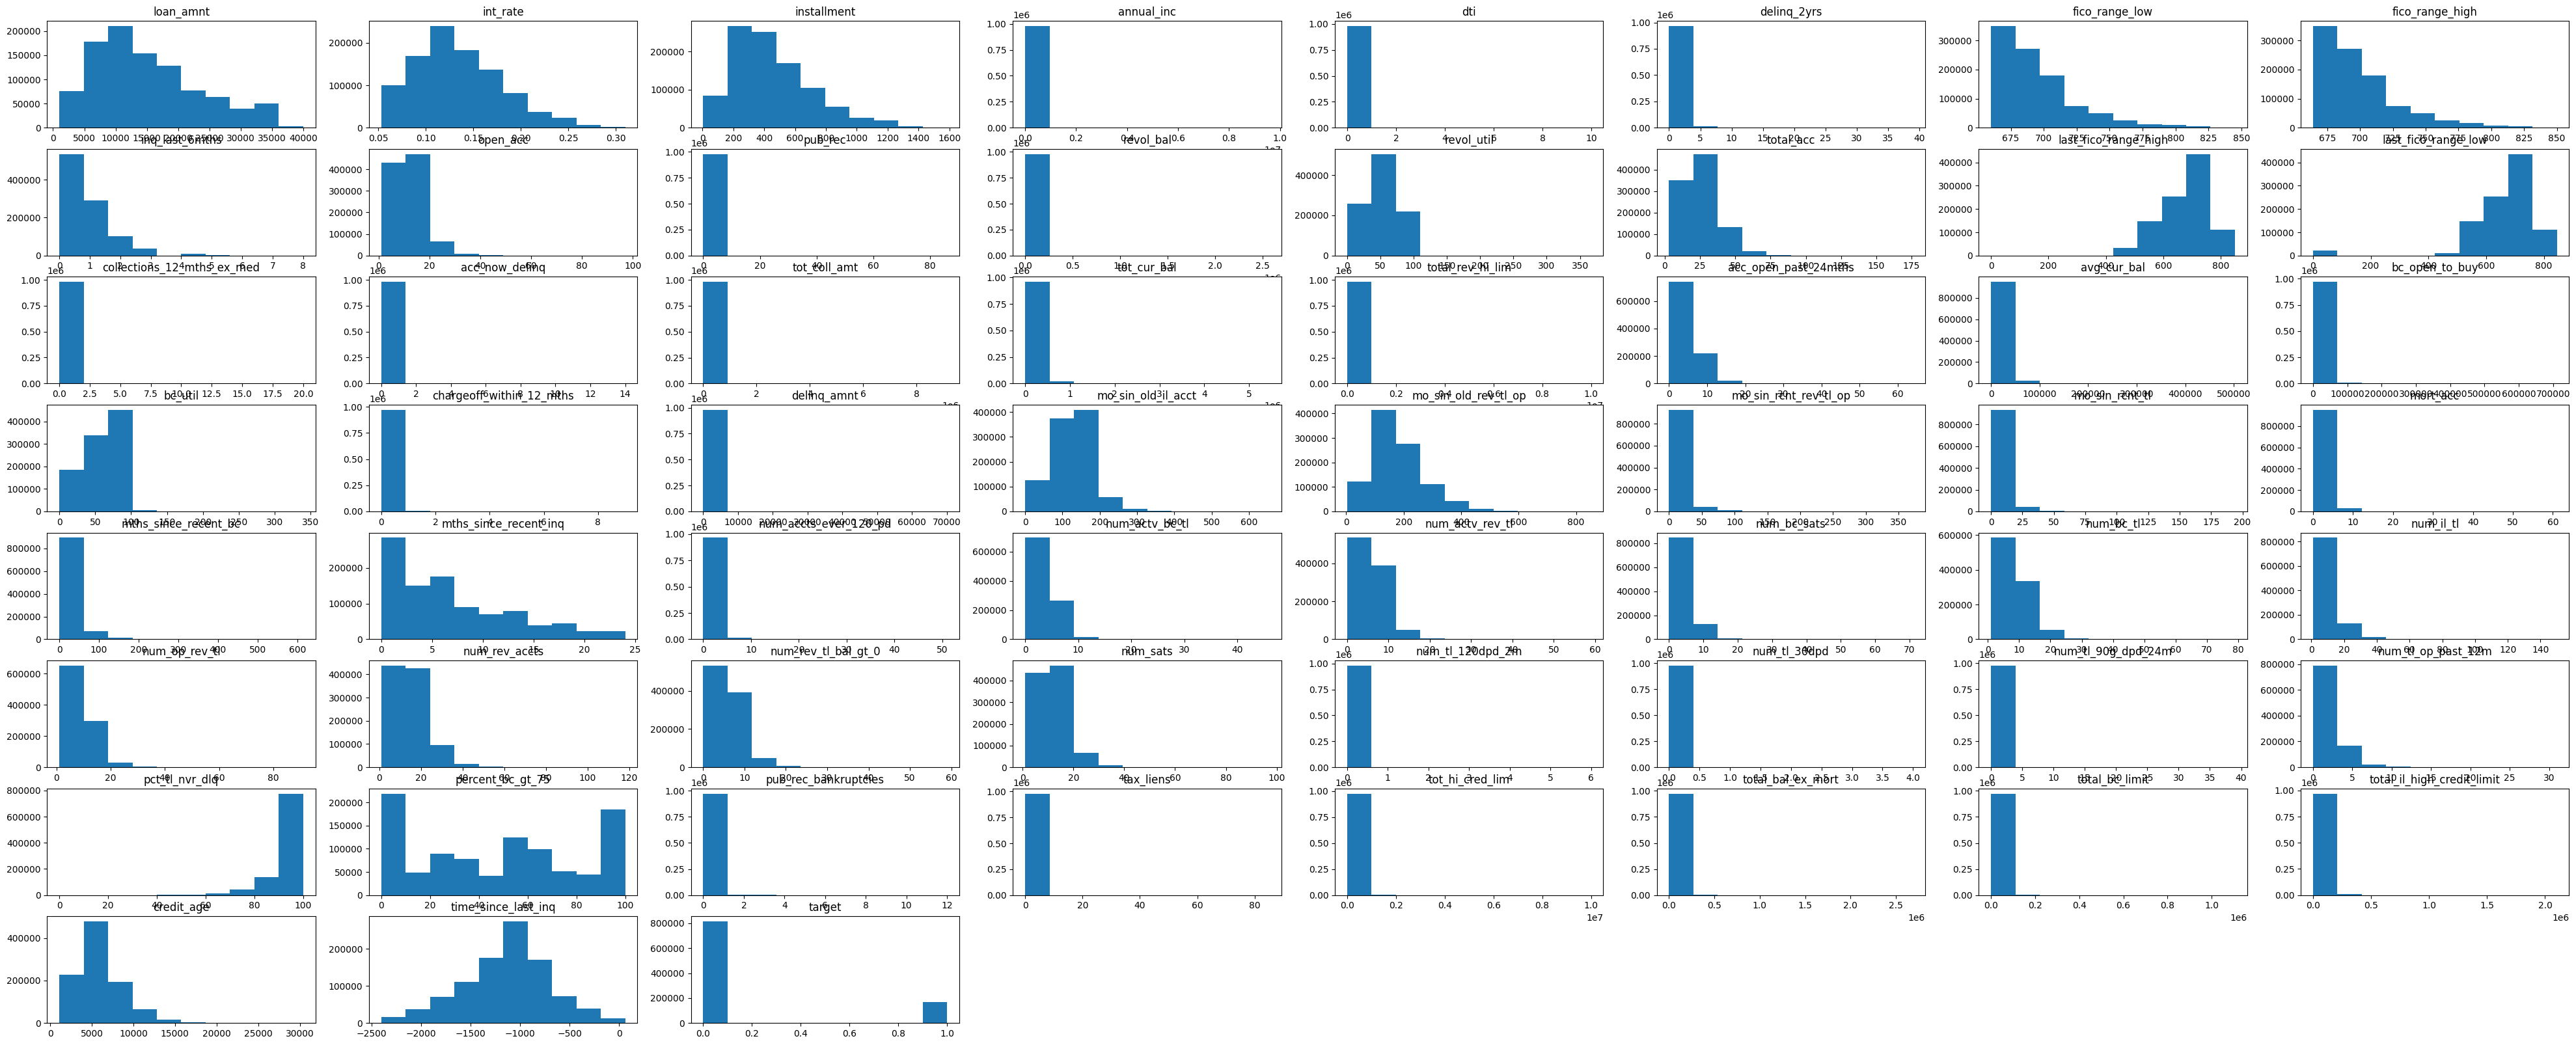

In [65]:
numerical = dropped.select_dtypes(exclude='O') 

plt.figure(figsize=(50, 20))
k = 0
cols = numerical.columns
for i, j in zip(range(len(cols)), cols):
    k +=1
    plt.subplot(8, 8, k)
    plt.hist(numerical.iloc[:, i])
    plt.title(j)


## modeling time

In [ ]:
#